# Variational Inference using PYMC4 & Bambi
This analysis uses a 5 year data set I previously created. The main objective of this notebook is to figure out how to get an interesting model, that runs in a reasonable amount of time.

## Quick Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import bambi as bmb

import aesara.tensor as at

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from scipy import stats

sns.set_style('whitegrid')

Could not locate executable g77
Could not locate executable f77
Could not locate executable ifort
Could not locate executable ifl
Could not locate executable f90
Could not locate executable DF
Could not locate executable efl


In [2]:
data = pd.read_csv('joined_crash_2017+2021.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 482367 entries, 0 to 482366
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   X                        482367 non-null  float64
 1   Y                        482367 non-null  float64
 2   OBJECTID                 482367 non-null  int64  
 3   DOCUMENT_NBR             482367 non-null  int64  
 4   CRASH_YEAR               482367 non-null  int64  
 5   CRASH_SEVERITY           482367 non-null  object 
 6   CRASH_DT                 482367 non-null  object 
 7   WEATHER_CONDITION        482367 non-null  object 
 8   LIGHT_CONDITION          482367 non-null  object 
 9   RD_TYPE                  482367 non-null  object 
 10  ROADWAY_ALIGNMENT        482367 non-null  object 
 11  ROADWAY_SURFACE_TYPE     482367 non-null  object 
 12  ROADWAY_DEFECT           482367 non-null  object 
 13  ROADWAY_DESCRIPTION      482367 non-null  object 
 14  TRFC

In [3]:
# correcting dtypes
type_dict = {c:'category' for c in data.columns if data[c].dtypes=='O'}
type_dict['CRASH_DT'] = 'datetime64'
type_dict['RURALURBANDESC'] = 'category'
type_dict['MEDIAN_TYPE'] = 'category'

data = data.astype(type_dict)

I will cut these columns because (1) they convey redundant information, (2) I don't understand them.

|**drop column**|**reason**|
|----------|----------|
|`RD_TYPE`|Interpretation Unclear|
|`AREA_TYPE`|Redundant with `RURALURBANDESC`|
|`SYSTEM`|Could be interesting, but I need to cut stuff|
|`SPEED_BEFORE`|behavior variable, not environmental variable|
|`SPEED_MAX_SAFE`|Redundant with `SPEED_POSTED` and environmental variables|
|`PAVEMENT_ROUGHNESSVALUE`|Interpretation Unclear/High Nullness|
|`MEDIAN_TYPE`|Redundant with `ROADWAY_DESCRIPTION`|


In [4]:
# drop columns above
data = data.drop(['RD_TYPE', 'AREA_TYPE', 'SYSTEM',
                  'PAVEMENT_ROUGHNESSVALUE',
                  'MEDIAN_TYPE'], axis=1)

# lower col names
data.columns = data.columns.str.lower()

In [5]:
for c in data.columns:
    if data[c].dtype.name=='category':
        print(f"\n\t{c}")
        print(data[c].value_counts().sort_index())


	crash_severity
A     23585
B     95455
C     37901
K      3177
O    322249
Name: crash_severity, dtype: int64

	weather_condition
1. No Adverse Condition (Clear/Cloudy)    398302
10. Blowing Sand, Soil, Dirt, or Snow        154
11. Severe Crosswinds                        243
3. Fog                                      2265
4. Mist                                     6531
5. Rain                                    65774
6. Snow                                     6695
7. Sleet/Hail                               1741
8. Smoke/Dust                                 13
9. Other                                     649
Name: weather_condition, dtype: int64

	light_condition
1. Dawn                                 13090
2. Daylight                            316350
3. Dusk                                 14305
4. Darkness - Road Lighted              64174
5. Darkness - Road Not Lighted          72373
6. Darkness - Unknown Road Lighting      1209
7. Unknown                                866


Next, I will flatten the levels of some categoricals.

|**flattened column**|**strategy**|
|--------------------|------------|
|`trfc_ctrl_status_type`|1. Yes 2. Yes - inhibited 3. No|
|`work_zone_location`|1. Yes 2. No|

Other ideas:  
+ Weather: Clear, Precip, Low Vis, Wind  
+ Light: Daylight, Dark, Low Sun
+ roadway_description: Two-Way, One-Way, Unknown

In [6]:
data['trfc_ctrl_status_type'] = data['trfc_ctrl_status_type'].map({'1. Yes - Working':'1. Yes', 
                                   '6. No Traffic Control Device Present':'3. No', 
                                   '3. Yes - Not Working':'2. Yes - inhibited', 
                                   '2. Yes - Working and Obscured':'2. Yes - inhibited', 
                                   '4. Yes - Not Working and Obscured':'2. Yes - inhibited', 
                                   '5. Yes - Missing':'2. Yes - inhibited'}).astype('category')

data['work_zone_location'] = data['work_zone_location'].map({'5. Not Work Area':'2. No', 
                                                             '3. Activity Area':'1. Yes', 
                                                             '4. Termination Area':'1. Yes', 
                                                             '1. Advance Warning Area':'1. Yes', 
                                                             '2. Transition Area':'1. Yes'}).astype('category')

# also remap ruralurbandesc
data['ruralurbandesc'] = data['ruralurbandesc'].map({1:'1. Rural',
                                                     2:'2. Small Urban',
                                                     3:'3. Urbanized',
                                                     4:'4. Urban'}).astype('category')

In [7]:
# scale numerics
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

data[['speed_before', 'speed_max_safe', 'speed_posted', 'numberoflane']] = scaler.fit_transform(data[['speed_before', 'speed_max_safe', 'speed_posted', 'numberoflane']])

I separate the data by years.

In [8]:
# prior_data = data.loc[data.crash_year.isin([2017, 2018, 2019])]
# train = data.loc[data.crash_year==2020]
# holdout = data.loc[data.crash_year==2021]
train = data.loc[data.crash_year.isin([2019, 2020, 2021])]

---

I further reduce the number of observations for quick testing.

In [9]:
# take a 3% stratified sample of 2020 data
# roughly 2500 observation

# from sklearn.model_selection import train_test_split
# trainx, _, trainy, _ = train_test_split(train.drop('crash_severity', axis=1), train['crash_severity'],
#                                       stratify = train['crash_severity'], train_size = 0.03,
#                                        random_state=40)

# train = trainx.merge(trainy ,left_index=True, right_index=True)
train.shape

(271456, 22)

In [10]:
train

,x,y,objectid,document_nbr,crash_year,crash_severity,crash_dt,weather_condition,light_condition,roadway_alignment,...,roadway_description,trfc_ctrl_status_type,work_zone_location,intersection_analysis,speed_before,speed_posted,speed_max_safe,direction_of_travel_cd,ruralurbandesc,numberoflane
210911,-76.219651,36.890357,513549,190325018,2019,O,2019-01-31 17:00:00,1. No Adverse Condition (Clear/Cloudy),2. Daylight,1. Straight - Level,...,"1. Two-Way, Not Divided",1. Yes,2. No,Urban Intersection,-1.647577,-0.821430,-0.110176,South,4. Urban,0.608857
210912,-77.444346,37.566686,513550,190505266,2019,O,2019-02-19 17:00:00,1. No Adverse Condition (Clear/Cloudy),2. Daylight,1. Straight - Level,...,"3. Two-Way, Divided, Positive Median Barrier",3. No,2. No,Urban Intersection,0.583584,-0.821430,-0.110176,North,4. Urban,-0.875810
210913,-77.430691,37.267645,513551,192885343,2019,O,2019-10-14 17:00:00,1. No Adverse Condition (Clear/Cloudy),1. Dawn,1. Straight - Level,...,"1. Two-Way, Not Divided",1. Yes,2. No,VDOT Intersection,-0.160136,0.760350,0.992450,West,1. Rural,0.608857
210914,-80.100966,37.293011,513552,192005288,2019,O,2019-07-19 17:00:00,1. No Adverse Condition (Clear/Cloudy),2. Daylight,1. Straight - Level,...,"3. Two-Way, Divided, Positive Median Barrier",1. Yes,2. No,Not Intersection,1.079398,0.760350,0.992450,North,1. Rural,-0.875810
210915,-76.445215,36.855562,513553,191025294,2019,O,2019-04-12 17:00:00,1. No Adverse Condition (Clear/Cloudy),2. Daylight,2. Curve - Level,...,"1. Two-Way, Not Divided",1. Yes,2. No,Not Intersection,0.335678,-0.030540,0.441137,South,4. Urban,3.578190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482362,-77.365572,38.960636,865811,212095188,2021,O,2021-07-28 17:00:00,1. No Adverse Condition (Clear/Cloudy),2. Daylight,1. Straight - Level,...,"3. Two-Way, Divided, Positive Median Barrier",1. Yes,2. No,Not Intersection,0.087771,-0.821430,-0.110176,East,4. Urban,0.608857
482363,-77.225814,38.680870,865813,211865235,2021,O,2021-06-30 17:00:00,1. No Adverse Condition (Clear/Cloudy),2. Daylight,1. Straight - Level,...,"3. Two-Way, Divided, Positive Median Barrier",1. Yes,2. No,Not Intersection,-0.903857,-0.821430,-0.110176,North,4. Urban,-1.618143
482364,-76.519016,37.124228,865814,212915489,2021,B,2021-10-18 17:00:00,1. No Adverse Condition (Clear/Cloudy),2. Daylight,3. Grade - Straight,...,"2. Two-Way, Divided, Unprotected Median",3. No,2. No,Not Intersection,0.583584,0.760350,0.441137,West,4. Urban,-0.133477
482365,-79.916431,36.841375,865815,213465102,2021,O,2021-12-11 17:00:00,4. Mist,5. Darkness - Road Not Lighted,4. Grade - Curve,...,"2. Two-Way, Divided, Unprotected Median",1. Yes,2. No,Not Intersection,-1.399670,-0.030540,0.441137,East,4. Urban,0.608857


---
# Model with Bambi

In [11]:
formu = ("crash_severity ~ weather_condition +"
         " light_condition +"
         " roadway_alignment +"
         " roadway_surface_type +"
         " roadway_defect +"
         " roadway_description +"
         " trfc_ctrl_status_type +"
         " work_zone_location +"
         " intersection_analysis +"
         " speed_posted +"
         "speed_before +"
         "speed_max_safe +"
         " direction_of_travel_cd +"
         " ruralurbandesc +"
         " numberoflane")

In [12]:
# subject_sd = bmb.Prior("HalfCauchy", beta=5)
subject_prior = bmb.Prior("Normal", mu=0, sigma=1e5)

priors = {"Intercept":subject_prior,
          "light_condition": subject_prior,
          "weather_condition": subject_prior,
          "roadway_alignment": subject_prior,
          'roadway_surface_type': subject_prior,
          'roadway_defect': subject_prior,
          'roadway_description': subject_prior,
          'trfc_ctrl_status_type': subject_prior,
          'work_zone_location': subject_prior, 
          'intersection_analysis': subject_prior,
          'speed_posted': subject_prior,
          'speed_before':subject_prior,
          'speed_max_safe':subject_prior,
          'speed_over_safe':subject_prior,
          'direction_of_travel_cd': subject_prior,
          'ruralurbandesc': subject_prior,
          'numberoflane': subject_prior}

In [13]:
model = bmb.Model(formula=formu, data=train, priors = priors, family='categorical')

fitted_vi = model.fit(method='vi', n=20000)

C:\Users\brook\anaconda3\envs\bambi\lib\site-packages\aesara\tensor\nnet\basic.py:1116: FutureWarning: Softmax now accepts an axis argument. For backwards-compatibility it defaults to -1 when not specified, but in the future the default will be `None`.
To suppress this warning specify axis explicitly.
  warnings.warn(


Finished [100%]: Average Loss = 2.6126e+05


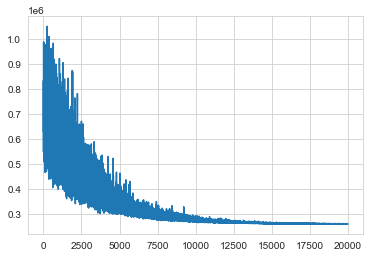

In [14]:
plt.plot(fitted_vi.hist)

In [15]:
model.terms

{'Intercept': Term(name: Intercept, prior: Normal(mu: 0, sigma: 100000.0), kind: intercept, shape: (271456,), categorical: False),
 'weather_condition': Term(name: weather_condition, prior: Normal(mu: 0, sigma: 100000.0), kind: categoric, shape: (271456, 9), categorical: True, levels: ['weather_condition[10. Blowing Sand, Soil, Dirt, or Snow]', 'weather_condition[11. Severe Crosswinds]', 'weather_condition[3. Fog]', 'weather_condition[4. Mist]', 'weather_condition[5. Rain]', 'weather_condition[6. Snow]', 'weather_condition[7. Sleet/Hail]', 'weather_condition[8. Smoke/Dust]', 'weather_condition[9. Other]']),
 'light_condition': Term(name: light_condition, prior: Normal(mu: 0, sigma: 100000.0), kind: categoric, shape: (271456, 6), categorical: True, levels: ['light_condition[2. Daylight]', 'light_condition[3. Dusk]', 'light_condition[4. Darkness - Road Lighted]', 'light_condition[5. Darkness - Road Not Lighted]', 'light_condition[6. Darkness - Unknown Road Lighting]', 'light_condition[7.

array([<AxesSubplot:title={'center':'speed_posted\nB'}>,
       <AxesSubplot:title={'center':'speed_posted\nC'}>,
       <AxesSubplot:title={'center':'speed_posted\nK'}>,
       <AxesSubplot:title={'center':'speed_posted\nO'}>], dtype=object)

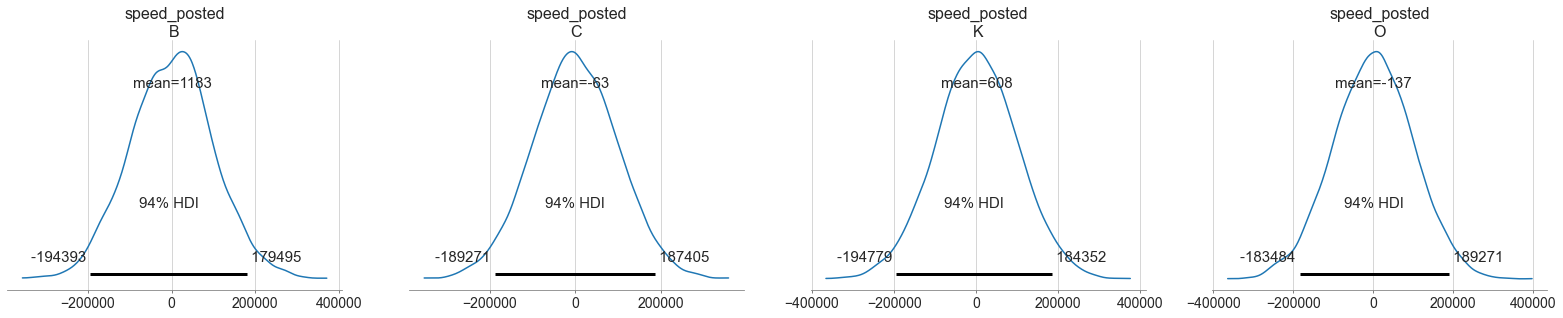

In [16]:
model.plot_priors(draws=10000, var_names=['speed_posted'])

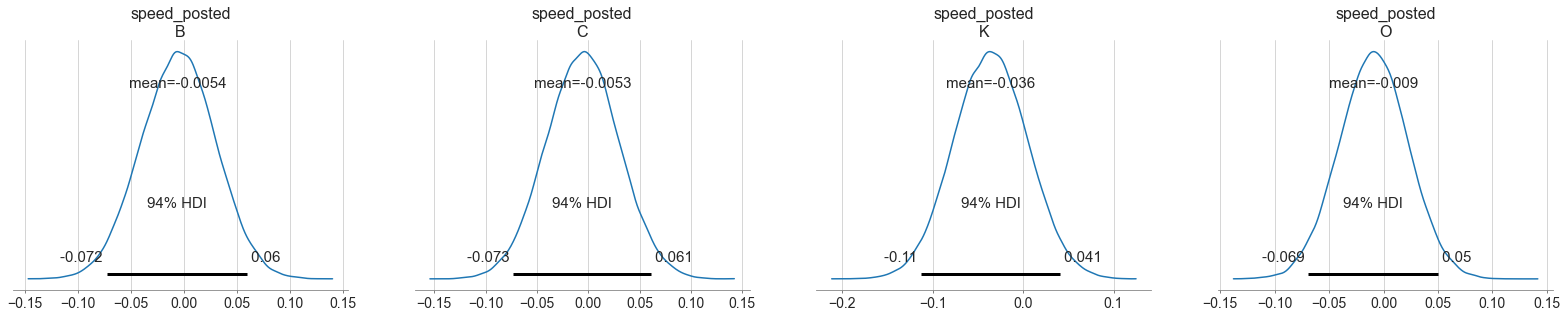

In [17]:
az.plot_posterior(fitted_vi.sample(50000), var_names="speed_posted")
plt.show()

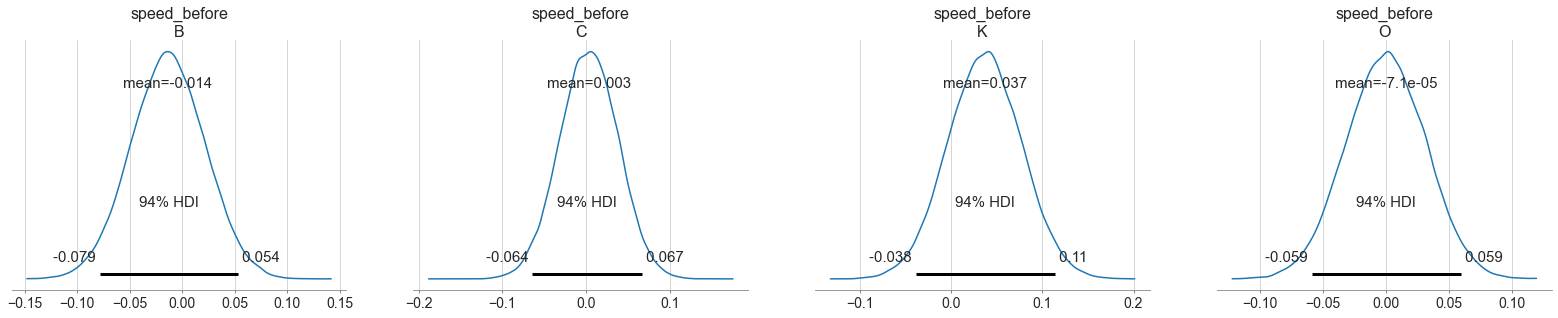

In [18]:
az.plot_posterior(fitted_vi.sample(50000), var_names="speed_before")
plt.show()

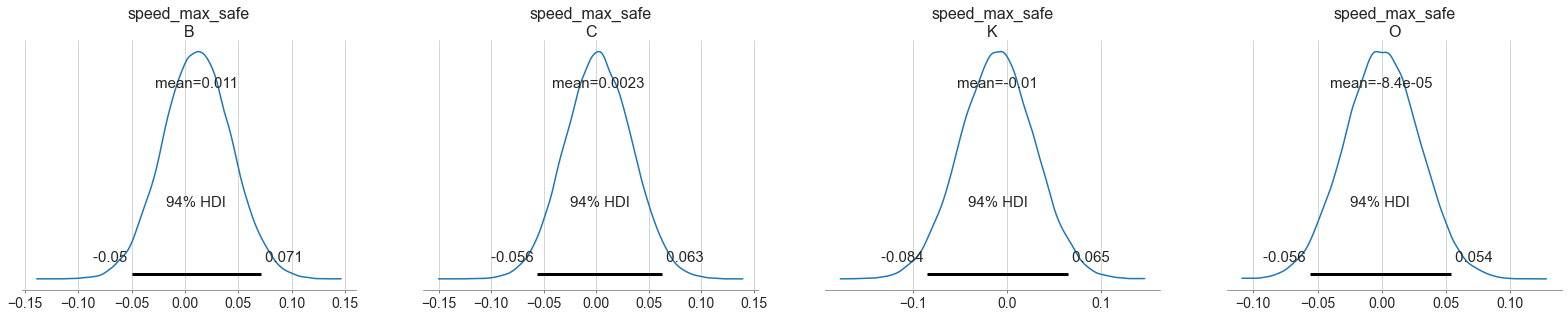

In [19]:
az.plot_posterior(fitted_vi.sample(50000), var_names="speed_max_safe")
plt.show()

In [21]:
samples_xarray = fitted_vi.sample(1000, random_seed=1)
samples = fitted_vi.sample(1000, random_seed=1, return_inferencedata=False)

In [22]:
gv1 = pm.model_to_graphviz(fitted_vi.model).unflatten(stagger=9)
gv1.render(filename='./graphviz_pdf1', format='pdf')

'graphviz_pdf1.pdf'

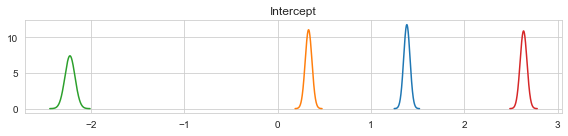

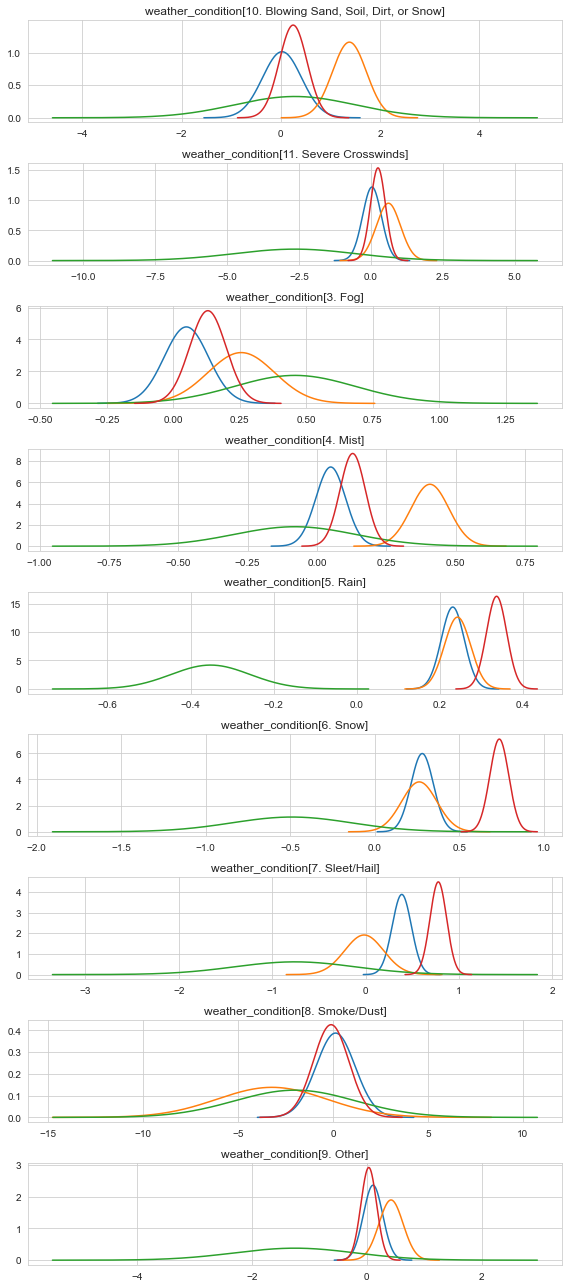

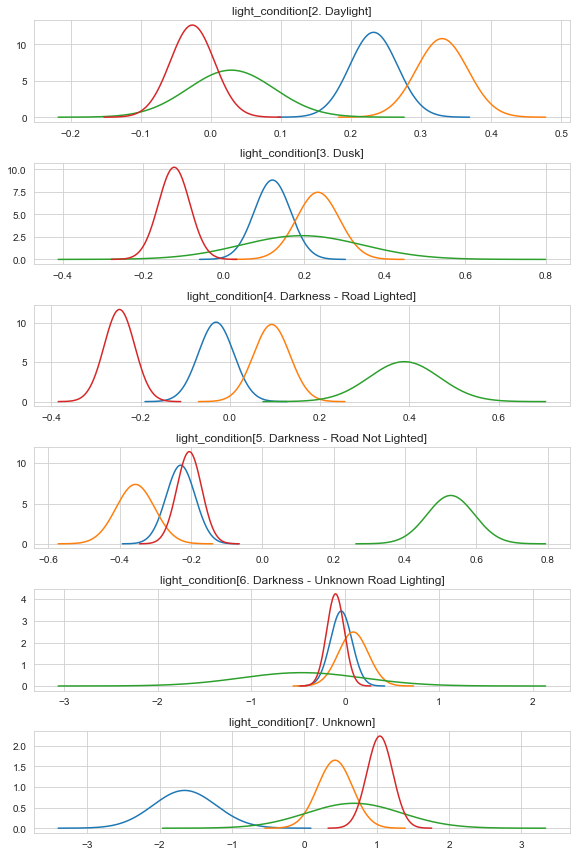

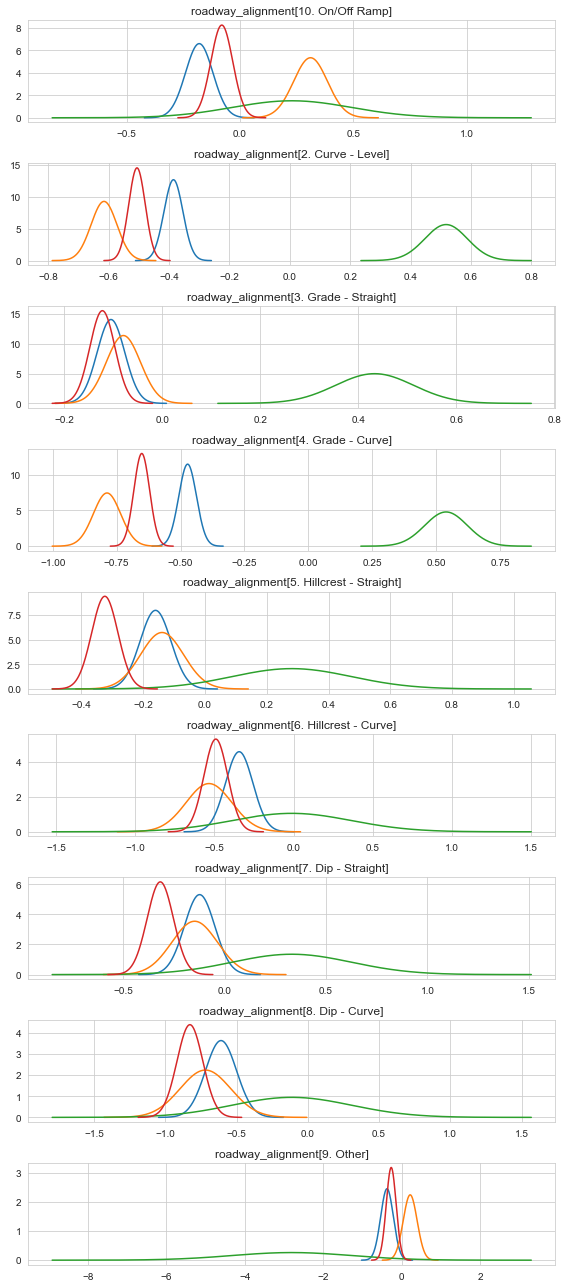

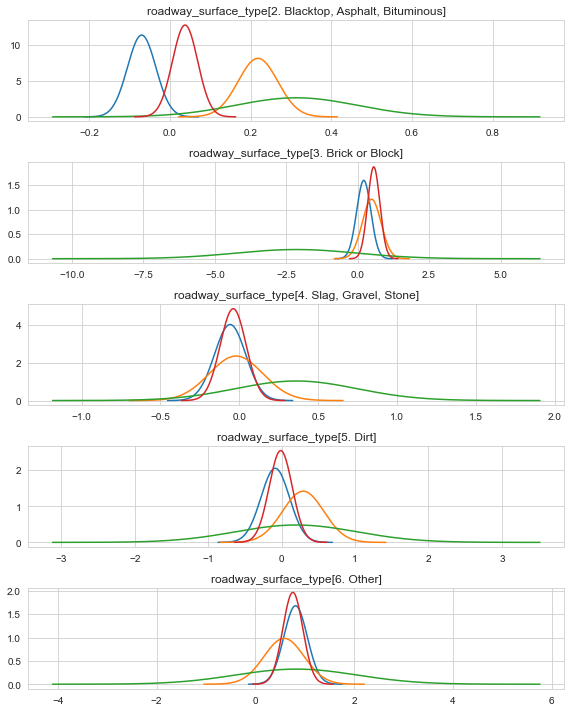

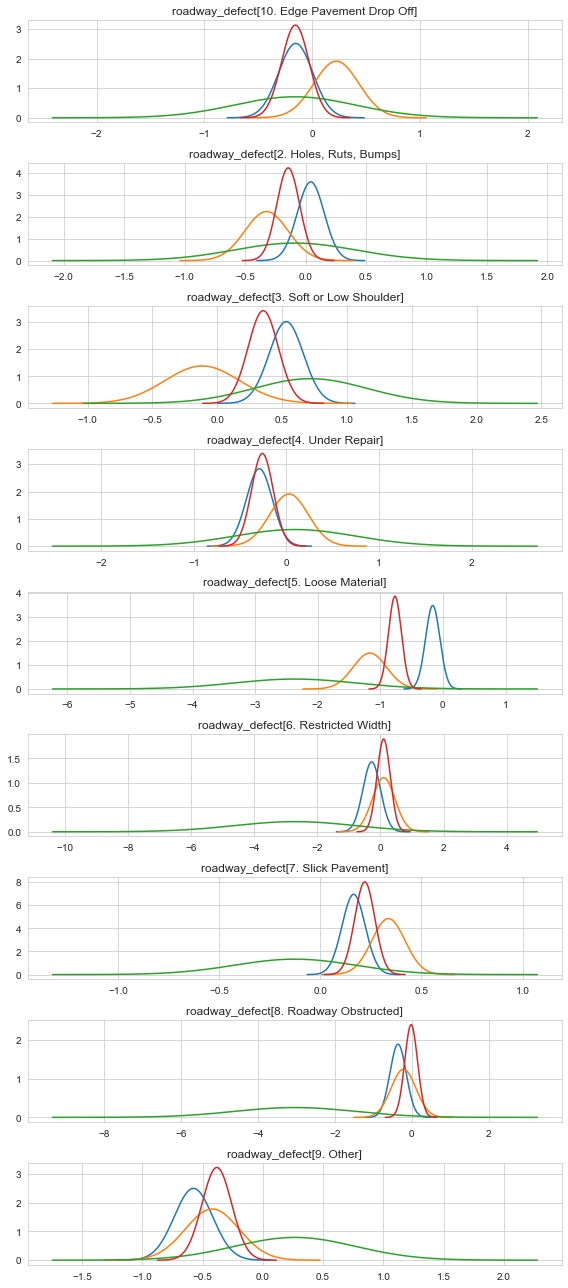

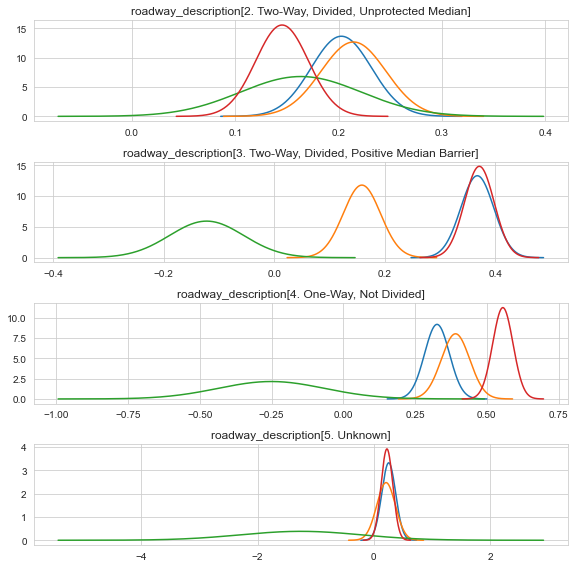

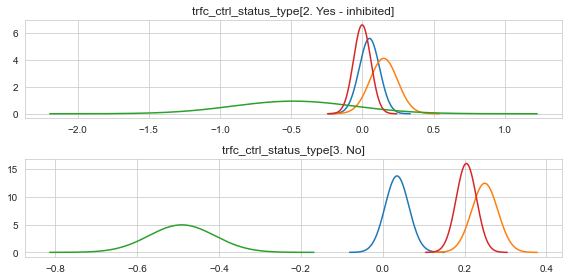

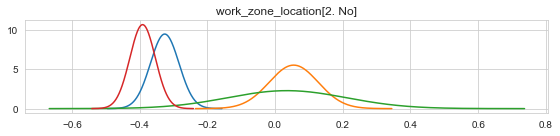

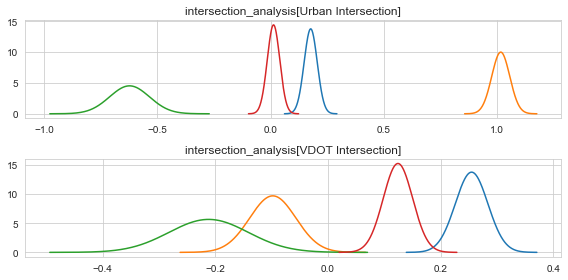

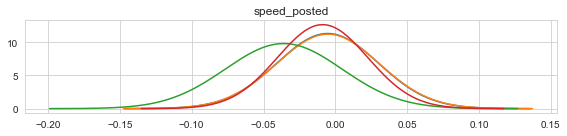

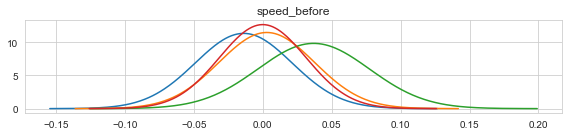

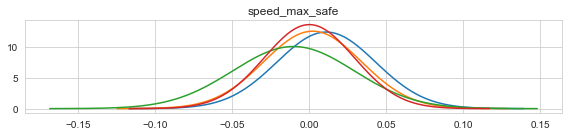

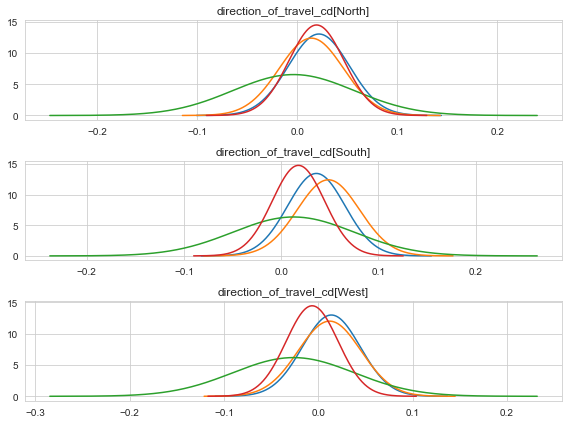

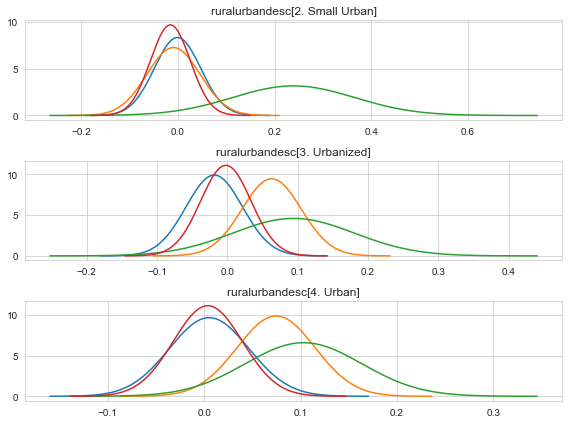

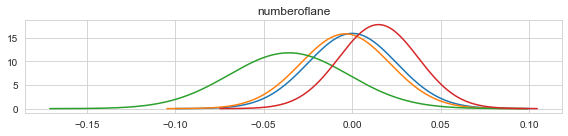

In [23]:
# ploterizer - requires approx object
# also requires model object for plot titles

order = fitted_vi.ordering
means = fitted_vi.mean.eval()
stds = fitted_vi.std.eval()



for obj in order:
    
    # if lvl_flag == 2, param is categorical w/ more than 2 levels
    lvl_flag = len(order[obj][2])
    
    # slice start/stop
    start = order[obj][1].start
    stop = order[obj][1].stop
    
    if lvl_flag == 1:
        plt.figure(figsize=(8,2), tight_layout=True)
        for i, (mu, sigma) in enumerate(zip(means[start:stop], stds[start:stop])):
            sd3 = (-4 * sigma + mu, 4 * sigma + mu)
            x = np.linspace(sd3[0], sd3[1], 400)
            y = stats.norm(mu, sigma).pdf(x)
            plt.plot(x,y)
            plt.title(model.terms[obj].levels[0])
        plt.show()
        
    if lvl_flag == 2:
        n_lvl = order[obj][2][0]
        fig, axs = plt.subplots(nrows=n_lvl, figsize = (8, 2*(n_lvl)))
        
        for lvl in np.arange(n_lvl):
            
            if n_lvl == 1:
                axs.set_title(model.terms[order[obj][0]].levels[lvl])

                mean_lvl= means[start+(4*lvl):start+(4*(lvl+1))]
                std_lvl = stds[start+(4*lvl):start+(4*(lvl+1))]

                sd3 = (-4*std_lvl+mean_lvl, 4*std_lvl+mean_lvl)
                x = np.linspace(sd3[0], sd3[1], 400)
                y = stats.norm(mean_lvl, std_lvl).pdf(x)
                axs.plot(x,y)
                
            else:
                axs[lvl].set_title(model.terms[order[obj][0]].levels[lvl])

                mean_lvl= means[start+(4*lvl):start+(4*(lvl+1))]
                std_lvl = stds[start+(4*lvl):start+(4*(lvl+1))]

                sd3 = (-4*std_lvl+mean_lvl, 4*std_lvl+mean_lvl)
                x = np.linspace(sd3[0], sd3[1], 400)
                y = stats.norm(mean_lvl, std_lvl).pdf(x)
                axs[lvl].plot(x,y)
        fig.tight_layout()
        plt.show()    

---
### Testing

In [24]:
model.response

ResponseTerm(name: crash_severity, shape: (271456,), levels: ['A', 'B', 'C', 'K', 'O'], reference: A)

In [25]:
order = fitted_vi.ordering
order['weather_condition'][0]

'weather_condition'

In [26]:
model.terms[order['weather_condition'][0]].levels[i]

'weather_condition[4. Mist]'

In [27]:
model.terms['speed_posted'].levels[0]

'speed_posted'